### SIDM with pyHalo

This notebook demonstrates how to generate realizations of self-interacting dark matter halos. It makes use of the python package SIDMpy (https://github.com/dangilman/SIDMpy)

In [8]:
from pyHalo.preset_models import SIDM
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

from sidmpy.Profiles.coreTNFW_deflection_angle import CoreTNFWDeflection
from sidmpy.sidmpy import solve_rho_with_interpolation
from sidmpy.CrossSections.tchannel import TChannel
from sidmpy.core_collapse_timescale import evolution_timescale_scattering_rate
from sidmpy.sidmpy import solve_sigmav_with_interpolation

This cell generates the realization of SIDM halos using the preset model SIDM

In [14]:
zlens, zsource = 0.4, 1.5

norm = 40. # asymptotic value of cross section at low velocity
v0 = 40. # velocity scale of the cross section (see Equation 1 in Gilman et al. 2021)
t_sub, t_field = 10., 100. # collapse timescales for subhalos and field halos

kwargs_cross_section = {'norm': norm, 'v_ref': v0}
cross_section_class = TChannel(**kwargs_cross_section)
logarithmic_core_collapse_slope = 3.
core_collapsed_core_size = 0.05
deflection_angle_function = CoreTNFWDeflection()
central_density_function = solve_rho_with_interpolation
evolution_timescale_function = evolution_timescale_scattering_rate
velocity_dispersion_function = solve_sigmav_with_interpolation
cross_section_name = 'TCHANNEL' 
# currently, only interpolated solutions for the central core density are implemented for the TCHANNEL model

realizationSIDM = SIDM(zlens, zsource, cross_section_name, cross_section_class, kwargs_cross_section,
         logarithmic_core_collapse_slope, core_collapsed_core_size,
         deflection_angle_function, central_density_function, evolution_timescale_function,
         velocity_dispersion_function, t_sub, t_field)

print('realization contains '+str(len(realizationSIDM.halos))+' halos.')
n_core_collapsed = 0
n_cored = 0
for halo in realizationSIDM.halos:
    if halo.mdef == 'coreTNFW':
        n_cored += 1
    else:
        n_core_collapsed += 1
print('number of core collapsed halos: ', n_core_collapsed)
print('number of cored halos: ', n_cored)

realization contains 3211 halos.
number of core collapsed halos:  537
number of cored halos:  2674


### Now we can compute the effective multiplane convergence with SIDM halos (similar to Figure 7 in Gilman et al. 2021)

In [17]:
lens_model_list, lens_redshift_array, kwargs_halos, numerical_deflection_class = realizationSIDM.lensing_quantities()

from lenstronomy.LensModel.lens_model import LensModel
# You should use the same astropy class created in pyhalo to do lensing computations
astropy_instance = realizationSIDM.astropy_instance
lens_model_halos_only = LensModel(lens_model_list, zlens, zsource, lens_redshift_array, cosmo=astropy_instance, multi_plane=True)

npix = 150 
grid_size = 1.4
_x = _y = np.linspace(-grid_size, grid_size, npix)
xx, yy = np.meshgrid(_x, _y)
shape0 = xx.shape

# power law plus shear macromodel
kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': 0., 'e1': 0.2, 'e2': -0.1, 'gamma': 2.},
                    {'gamma1': -0.03, 'gamma2': 0.02}]

lens_model_list_macro = ['EPL', 'SHEAR']
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos

lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True, 
                            numerical_alpha_class=numerical_deflection_class)
lens_model_macro = LensModel(lens_model_list_macro)

kappa_full = lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
kappa_macro = lens_model_macro.kappa(xx.ravel(), yy.ravel(), kwargs_macromodel).reshape(shape0)

from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
lens_model_extension = LensModelExtensions(lens_model_full)
grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)

### Make the figure

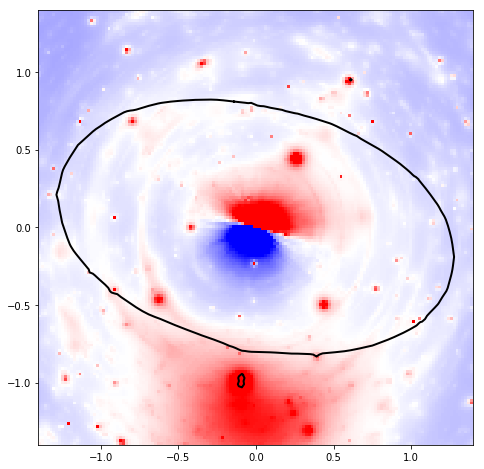

In [18]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_subs_nonlinear = kappa_full - kappa_macro

# subtracting the mean can make halos appear more clearly 
mean = np.mean(kappa_subs_nonlinear)
plt.imshow(kappa_subs_nonlinear - mean, vmin=-0.05, vmax=0.05, cmap='bwr', extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

for i in range(0, len(ra_crit_list)):
    plt.plot(ra_crit_list[i], dec_crit_list[i], color='k', lw=2)



We can also generate population of core-collapsed halos by specifying the mass range, and the fraction of collapsed halos in the mass range, for both subhalos and field halos

In [5]:
from pyHalo.preset_models import CDM
from pyHalo.single_realization import SingleHalo
from pyHalo.realization_extensions import RealizationExtensions

realization = CDM(zlens, zsource)
mass_range_subs = [[6, 8], [8, 10]]
mass_range_field = [[6, 8], [8, 10]]
p_subs = [0.8, 0.4]
p_field = [0., 0.]
kwargs_halo = {'log_slope_halo': 3., 'x_core_halo': 0.05}

ext = RealizationExtensions(realization)
inds = ext.core_collapse_by_mass(mass_range_subs, mass_range_field,
                      p_subs, p_field)
realization_with_core_collapse = ext.add_core_collapsed_halos(inds, **kwargs_halo)

lens_model_list, lens_redshift_array, kwargs_halos, _ = realization_with_core_collapse.lensing_quantities()

In [6]:
lens_model_list_full = lens_model_list_macro + lens_model_list
lens_redshift_list_full = [zlens, zlens] + list(lens_redshift_array)
kwargs_lens_full = kwargs_macromodel + kwargs_halos
lens_model_full = LensModel(lens_model_list_full, zlens, zsource, 
                            lens_redshift_list_full, cosmo=astropy_instance, multi_plane=True)

kappa_full =lens_model_full.kappa(xx.ravel(), yy.ravel(), kwargs_lens_full).reshape(shape0)
lens_model_extension = LensModelExtensions(lens_model_full)
grid_resolution = 0.02 # this can take a while for higher resolution computations of the critical curves
ra_crit_list, dec_crit_list, _, _ = lens_model_extension.critical_curve_caustics(kwargs_lens_full, 
                                                                compute_window=2*grid_size, grid_scale=grid_resolution)

## Make the figure

[[0.20234237 0.20358643 0.20493486 ... 0.25413061 0.25286034 0.25168599]
 [0.20437893 0.20567514 0.20709319 ... 0.25658352 0.2553133  0.25412236]
 [0.20656838 0.20790159 0.20939114 ... 0.25916067 0.25790988 0.25674161]
 ...
 [0.26149889 0.26297637 0.26463427 ... 0.21003705 0.20958292 0.20941597]
 [0.25910379 0.26043167 0.26202755 ... 0.20833404 0.20840034 0.2091775 ]
 [0.25682192 0.25792725 0.25950002 ... 0.20685992 0.2081046  0.21425085]]


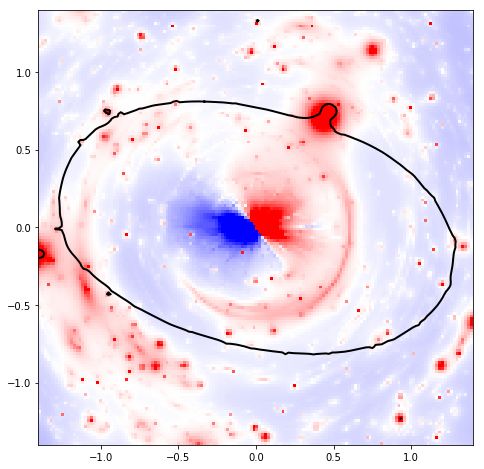

In [7]:
fig = plt.figure(1)
fig.set_size_inches(8,8)
kappa_nonlinear = kappa_full - kappa_macro
print(kappa_full)
# subtracting the mean can make halos appear more clearly 
mean = np.mean(kappa_nonlinear)
plt.imshow(kappa_nonlinear - mean, vmin=-0.05, vmax=0.05, cmap='bwr', 
           extent=[-grid_size, grid_size, -grid_size, grid_size], origin='lower')

for i in range(0, len(ra_crit_list)):
    plt.plot(ra_crit_list[i], dec_crit_list[i], color='k', lw=2)

